In [1]:
import os
import torch
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
R_STATE = 76
TEST_SIZE = 0.15
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 300

In [3]:
np.random.seed(R_STATE)

# Additional data

In [4]:
# weather data = 'https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016'

weather = pd.read_csv('data/weather.csv')
weather.head(3)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


# Reading data from dataset

In [5]:
# train

df = pd.read_csv('data/train.csv')
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [6]:
# test

test_set = pd.read_csv('data/train.csv')
test_set.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 366 non-null    object 
 1   maximum temperature  366 non-null    int64  
 2   minimum temperature  366 non-null    int64  
 3   average temperature  366 non-null    float64
 4   precipitation        366 non-null    object 
 5   snow fall            366 non-null    object 
 6   snow depth           366 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


# EDA

latitude [min= 34.35969543457031, max= 51.88108444213867]


<AxesSubplot:ylabel='pickup_latitude'>

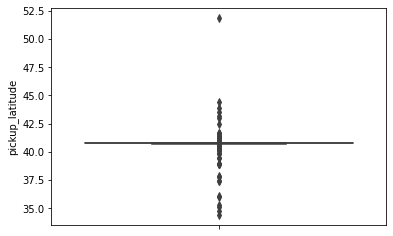

In [10]:
print(f'latitude [min= {df.pickup_latitude.min()}, max= {df.pickup_latitude.max()}]')

sns.boxplot(data= df, y= df.pickup_latitude)

latitude [min= -121.93334197998048, max= -61.33552932739258]


<AxesSubplot:ylabel='pickup_longitude'>

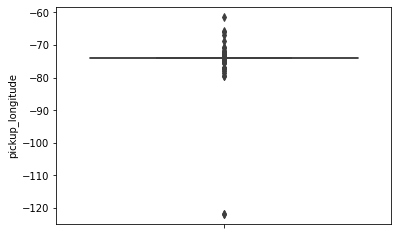

In [11]:
print(f'latitude [min= {df.pickup_longitude.min()}, max= {df.pickup_longitude.max()}]')

sns.boxplot(data= df, y= df.pickup_longitude)

Text(0.5, 1.0, 'Test set')

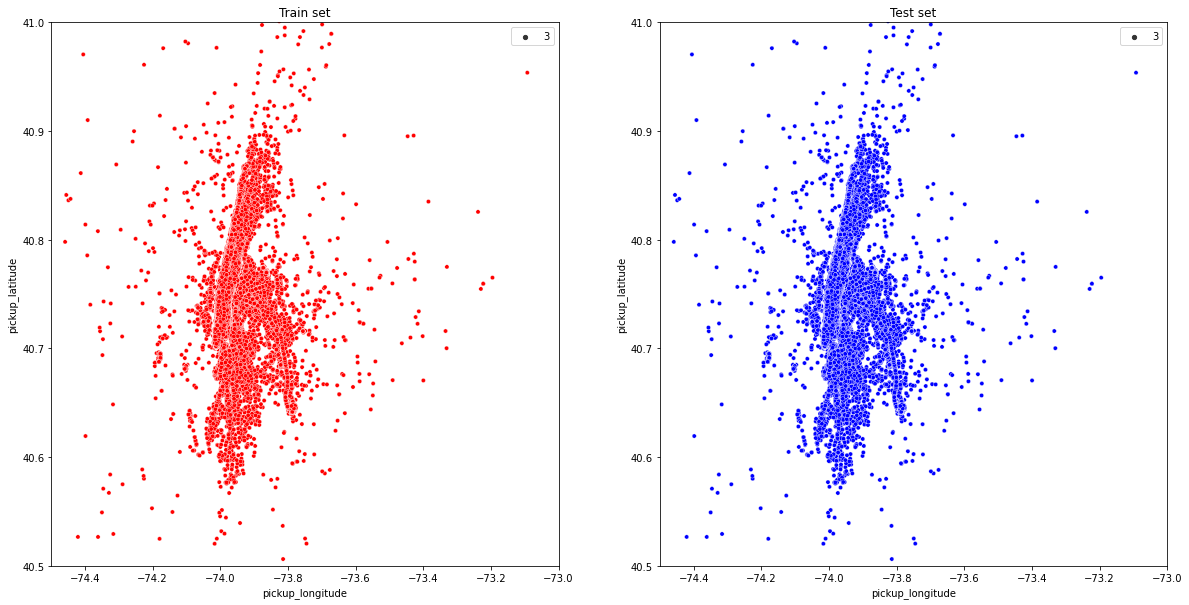

In [12]:
fig, axs = plt.subplots(1,2, figsize= (20,10))


axs[0].set_xlim([-74.5, -73])
axs[0].set_ylim([40.5, 41])

axs[1].set_xlim([-74.5, -73])
axs[1].set_ylim([40.5, 41])

sns.scatterplot(data= df, x= df.pickup_longitude, y= df.pickup_latitude, size=3, ax= axs[0], color= 'red').set_title('Train set')
sns.scatterplot(data= df, x= test_set.pickup_longitude, y= test_set.pickup_latitude, size=3, ax= axs[1], color= 'blue').set_title('Test set')

### NOTE: train and test sets are homogenious
### Drop outliers

In [13]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [14]:
# So where is the most amount of data? (longtitude and latitude boundres)


print("longtitude boundres [-74.5, -73.5] data % = " + f'{"%.5f" % (((df.pickup_longitude > -74.5) & (df.pickup_longitude < -73.5)).sum() / df.shape[0])}')

print("longtitude boundres [40.5, 41] data % = " + f'{"%.5f" % (((df.pickup_latitude > 40.5) & (df.pickup_latitude < 41)).sum() / df.shape[0])}')

longtitude boundres [-74.5, -73.5] data % = 0.99995
longtitude boundres [40.5, 41] data % = 0.99992


In [15]:
df.shape

(1458644, 11)

In [16]:
df.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [17]:
# drop outliers


# pickup_longitude
df = df.drop(df[(df.pickup_longitude < -74.5)].index)
df = df.drop(df[(df.pickup_longitude > -73.5)].index)

# pickup_latitude
df = df.drop(df[(df.pickup_latitude < 40.5)].index)
df = df.drop(df[(df.pickup_latitude > 41)].index)

# passenger_count
df = df.drop(df[df.passenger_count > 5].index)

df.shape


(1410155, 11)

## Weather data

In [18]:
weather.head(3)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


In [19]:
print(f"precipitation == 'T' -> {(weather.precipitation == 'T').sum()} \nsnow fall == 'T' -> {(weather['snow fall'] == 'T').sum()} \nsnow depth == 'T' -> {(weather['snow depth'] == 'T').sum()}")

# https://en.wikipedia.org/wiki/Trace_(precipitation)
# so let's null all 'T' values

precipitation == 'T' -> 24 
snow fall == 'T' -> 15 
snow depth == 'T' -> 7


In [20]:
weather.loc[weather.precipitation == 'T', 'precipitation'] = '0.00'
weather.precipitation = weather.precipitation.astype('float')

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype('float')

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype('float')

## Merge train and weather data by date

In [21]:
df['date'] = df.pickup_datetime.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
weather['date'] = weather.date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

In [22]:
df_new = pd.merge(df, weather, how= 'left', on= 'date')
df_new.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,51,40,45.5,0.29,0.0,0.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,83,62,72.5,0.00,0.0,0.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,28,16,22.0,0.00,0.0,0.0


In [23]:
df_new.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

## Date columns into hours, month, year (with holidays indicator)

In [24]:
df_new['pickup_datetime'] = pd.to_datetime(df_new['pickup_datetime'])

df_new['pickup_month'] = df_new['pickup_datetime'].apply(lambda x: x.month)
df_new['pickup_day'] = df_new['pickup_datetime'].apply(lambda x: x.day)
df_new['pickup_day_of_week'] = df_new['pickup_datetime'].apply(lambda x: x.dayofweek)
df_new['pickup_hour'] = df_new['pickup_datetime'].apply(lambda x: x.hour)
df_new['pickup_minute'] = df_new['pickup_datetime'].apply(lambda x: x.minute)

df_new['pickup_weekends'] = df_new['pickup_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_new['store_and_fwd_flag'] = 1 * (df_new.store_and_fwd_flag.values == 'Y')

In [25]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

df_new['pickup_holiday'] = df_new['date'].isin(holidays)
df_new['pickup_holiday'] = df_new['pickup_holiday'].map(lambda x: 1 if x == True else 0)

df_new['pickup_near_holiday'] = df_new['date'].isin(holidays + timedelta(days= 1)) | df_new['date'].isin(
    holidays - timedelta(days= 1))
df_new['pickup_near_holiday'] = df_new['pickup_near_holiday'].map(lambda x: 1 if x == True else 0)

df_new.head(3)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow fall,snow depth,pickup_month,pickup_day,pickup_day_of_week,pickup_hour,pickup_minute,pickup_weekends,pickup_holiday,pickup_near_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,0.0,0.0,3,14,0,17,24,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,0.0,0.0,6,12,6,0,43,1,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,0.0,0.0,1,19,1,11,35,0,0,1


## Trip distance and avg speed

In [26]:
from math import radians, cos, sin, asin, sqrt


def geodistance(data):

    lng1 = data['pickup_longitude']
    lat1 = data['pickup_latitude']
    lng2 = data['dropoff_longitude']
    lat2 = data['dropoff_latitude']

    lng1, lat1, lng2, lat2 = map (radians, [float (lng1), float (lat1), float (lng2), float (lat2)]) # lat ang long to radiance
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    distance = 2 * asin (sqrt (a)) * 6371 * 1000 # r of the Earth 6371 km
    distance=round(distance/1000,3)
    return distance

In [27]:
df_new['total_distance'] = df_new[['pickup_longitude' , 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(geodistance, axis= 1)

## Target value

In [28]:
df_new.trip_duration.describe()

count    1.410155e+06
mean     9.560380e+02
std      5.264816e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

<AxesSubplot:xlabel='trip_duration', ylabel='Count'>

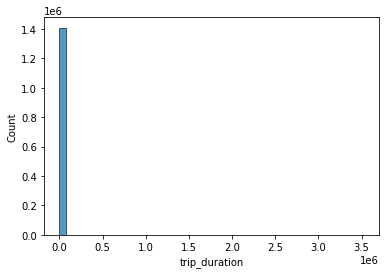

In [29]:
sns.histplot(data= df_new, x= df_new.trip_duration, bins= 50)

In [30]:
# log target value

df_new = df_new.assign(log_trip_duration= np.log(df_new.trip_duration + 1))

<AxesSubplot:xlabel='log_trip_duration', ylabel='Count'>

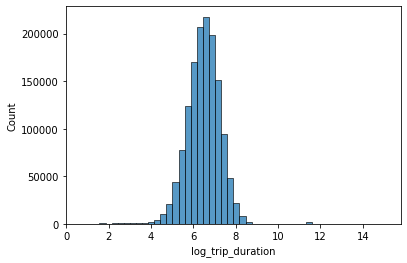

In [31]:
sns.histplot(data= df_new, x= df_new.log_trip_duration, bins= 50)

# Global view

<AxesSubplot:>

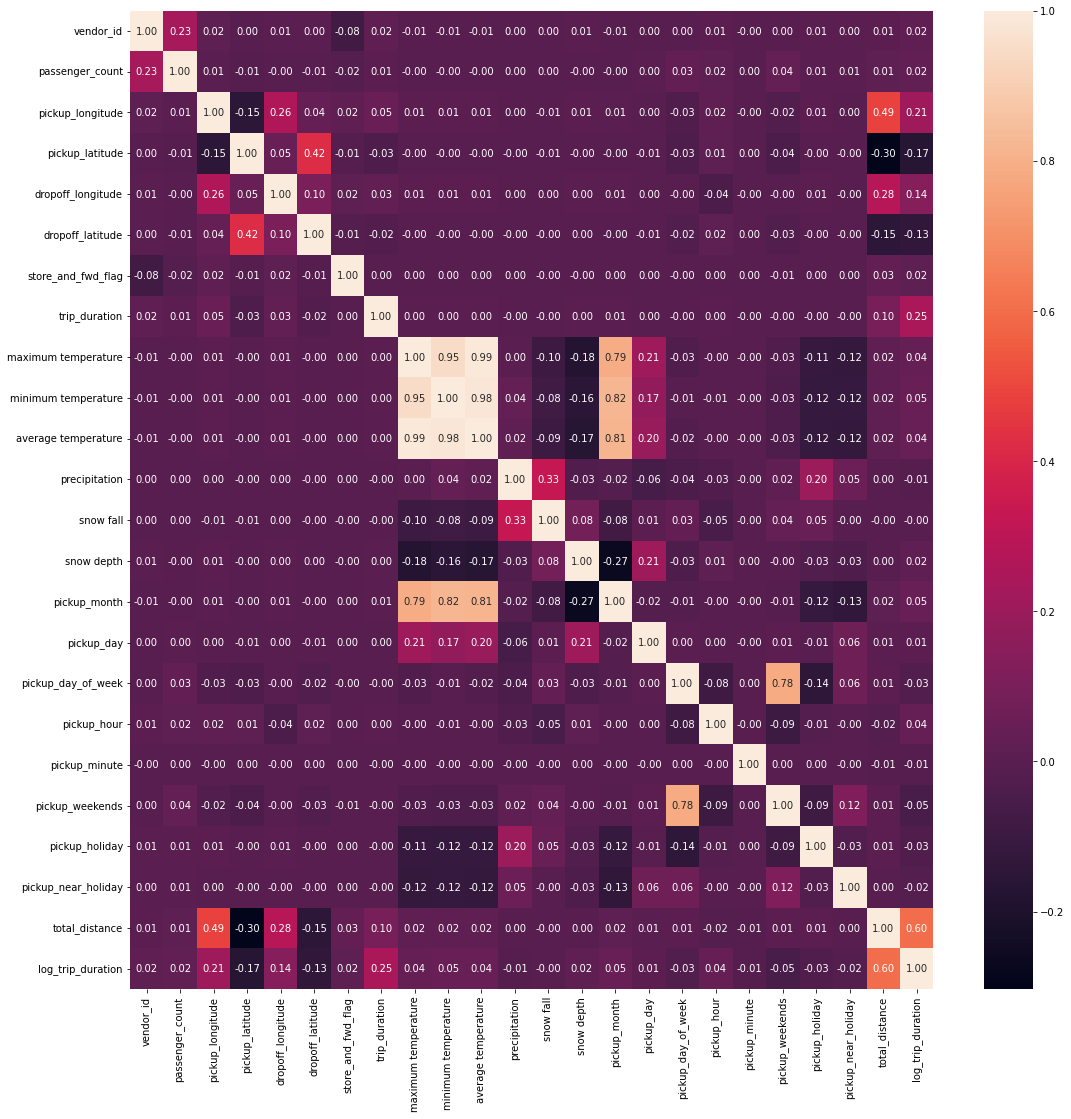

In [32]:
plt.figure(figsize= (18,18))
sns.heatmap(df_new.corr(), annot= True, fmt= '.2f')

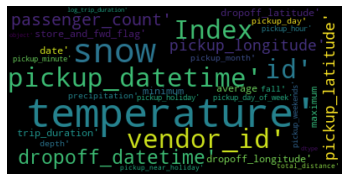

In [36]:
from wordcloud import WordCloud

text = str(df_new.columns)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()